## 1. Study Design
Read the Readme file in the main repo

## 2. Analysis

### Data Cleaning
- We first need to make sure there no back images in our list
- We will use tools to retrieve images

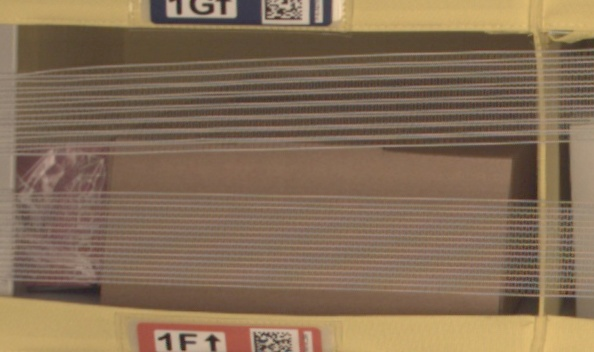

In [14]:


def get_abid_img(idx:int):
    """
    Retrieves a PIL Image from an image index.

    Parameters:
        idx (int) : index from the ABID Challenge Dataset.

    Returns:
        PIL.Image.Image: The PIL Image object if successful.
        None: If there is an error.
    """
    s3 = boto3.client('s3')
    bucket_name = "aft-vbi-pds"
    object_key = f"bin-images/{idx}.jpg"
    
    
    try:
        # Fetch the object from S3
        response = s3.get_object(Bucket=bucket_name, Key=object_key)
        
        # Read the content and load it as a PIL image
        image_data = response['Body'].read()
        pil_image = Image.open(BytesIO(image_data))
        
        return pil_image
    except Exception as e:
        return None

get_abid_img(83501)

### Data Collection
- The Study uses the Amazon Bin Dataset, which is already hosted by Amazon in https://registry.opendata.aws/amazon-bin-imagery/
- Basing ourselves in the repository https://github.com/silverbottlep/abid_challenge/tree/master we created to files which simplifies metadata to the format we needed for the specific task
- For training counting_train_hard.json
- For validation counting_val_hard.json
- Both json files are a list of tuples the first integer is the name of the jpg image file in the registry hosted by amazon and the second is the number of items
- Let's first study the target values

In [1]:
# Exploring Dataset
import json
import numpy as np
import matplotlib.pyplot as plt

train = []
with open("counting_train_hard.json") as f:
    train = json.load(f)

valid = []
with open("counting_val_hard.json") as f:
    valid = json.load(f)
    
print(f"Training Dataset Lenght {len(train)}")
print(f"Validation Dataset Lenght {len(valid)}")
print(f"Total Dataset Samples {len(train)+len(valid)}")

Training Dataset Lenght 481711
Validation Dataset Lenght 53523
Total Dataset Samples 535234


In [2]:
import pandas as pd

# Create pandas dataset from the json Files
train_pd = pd.DataFrame(train)
valid_pd = pd.DataFrame(valid)

In [3]:
## Describe the Dataset we are dealing with
train_summary = train_pd.iloc[:, 1].describe(percentiles=[0.001, 0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999])
valid_summary = valid_pd.iloc[:, 1].describe(percentiles=[0.001, 0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.999])
print(f"Training Dataset Description:\n{train_summary}\n")
print(f"Validation Dataset Description:\n{valid_summary}")

Training Dataset Description:
count    481711.000000
mean          5.116888
std           4.655778
min           0.000000
0.1%          0.000000
1%            0.000000
5%            1.000000
10%           2.000000
25%           3.000000
50%           4.000000
75%           6.000000
90%           9.000000
95%          12.000000
99%          21.000000
99.9%        50.000000
max         209.000000
Name: 1, dtype: float64

Validation Dataset Description:
count    53523.000000
mean         5.079274
std          4.316334
min          0.000000
0.1%         0.000000
1%           0.000000
5%           1.000000
10%          2.000000
25%          3.000000
50%          4.000000
75%          6.000000
90%          9.000000
95%         12.000000
99%         20.000000
99.9%       48.000000
max        111.000000
Name: 1, dtype: float64


### Analysis from previous descriptions
We are interest in dealing with most of the case not all, following on that we will get values until 12 objects which would take care of 95% of the cases, depending on the result later on we can expand this is further research

In [4]:
# Create a clipped dataset, we will use same lower and upper bound for train and valid dataset to keep consistency
lower_bound = 0
upper_bound = int(train_summary['95%'])
train_clipped = train_pd[(train_pd.iloc[:, 1] >= lower_bound) & (train_pd.iloc[:, 1] <= upper_bound)]
valid_clipped = valid_pd[(valid_pd.iloc[:, 1] >= lower_bound) & (valid_pd.iloc[:, 1] <= upper_bound)]

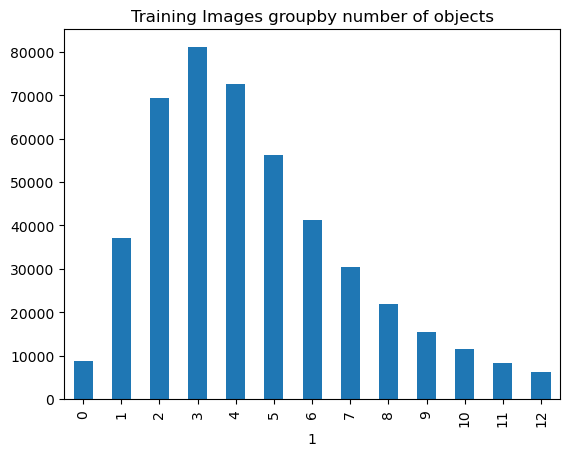

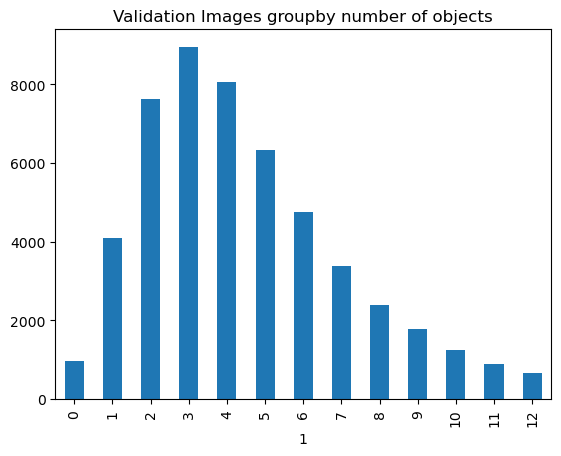

In [5]:
# We then procedd to group sample by number of objects
train_groups = train_clipped.groupby(1) # We use the second column which the number of object in the image
train_groups.size().plot(kind='bar', title="Training Images groupby number of objects")
plt.show()
valid_groups = valid_clipped.groupby(1)
valid_groups.size().plot(kind='bar', title="Validation Images groupby number of objects")
plt.show()

### Analysis from previous results
- From previous plots we see that we have distribution skewed to the left, when using deep learning techniques for images to avoid training issue we need a balanced dataset across categories.
- For that reason we will create a dataset with equal number of images per category
- When we design the study we decided to use 5000 samples for aproximate 1% of the complete dataset
- As we have 13 categories we will use 400 sample per category for a total of 5200 images
- In the validation dataset we will use 80 samples per category for a total of 1040 images
- We will use batch size of 13 samples, so if we get one sample per category we get 400 batches                                                      

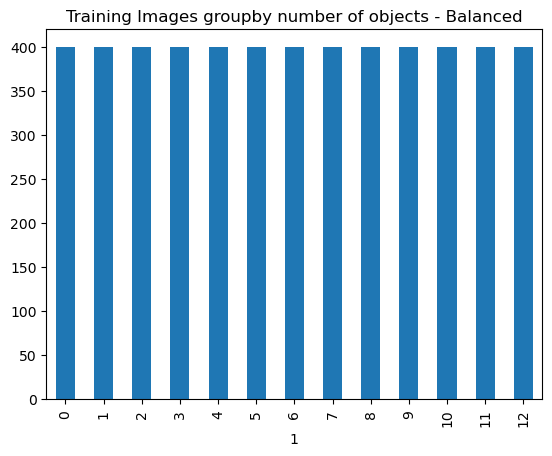

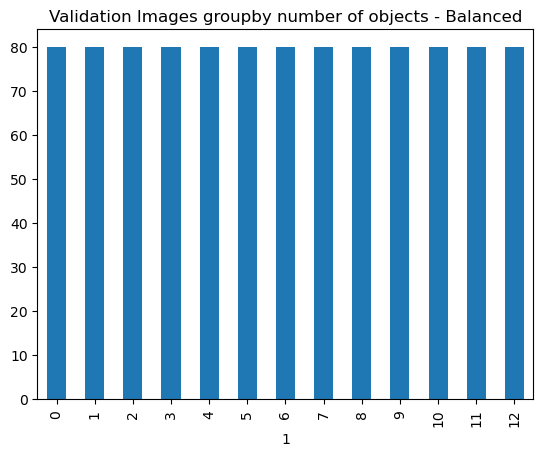

In [16]:
# We fist balanced the dataset and make sure everything is balanced

N_TRAIN_BATCHES = 400
train_balanced = train_groups.sample(n=N_TRAIN_BATCHES, random_state=42).groupby(1)
train_balanced.size().plot(kind='bar', title="Training Images groupby number of objects - Balanced")
plt.show()
N_VALID_BATCHES = 80
valid_balanced = valid_groups.sample(n=N_VALID_BATCHES, random_state=42).groupby(1)
valid_balanced.size().plot(kind='bar', title="Validation Images groupby number of objects - Balanced")
plt.show()

In [17]:
# We then proced to get it formated as batches
ntrain = []
nvalid = []

for x in range(N_TRAIN_BATCHES):
    batch = train_balanced.nth(x)
    ntrain.append(batch.values.tolist())

for x in range(N_VALID_BATCHES):
    batch = valid_balanced.nth(x)
    nvalid.append(batch.values.tolist())

with open('counting_filtered_train.json', 'w', encoding='utf-8') as f:
    json.dump(ntrain, f, indent=4)

with open('counting_filtered_valid.json', 'w', encoding='utf-8') as f:
    json.dump(nvalid, f, indent=4)

### Tool to Retrieve Images

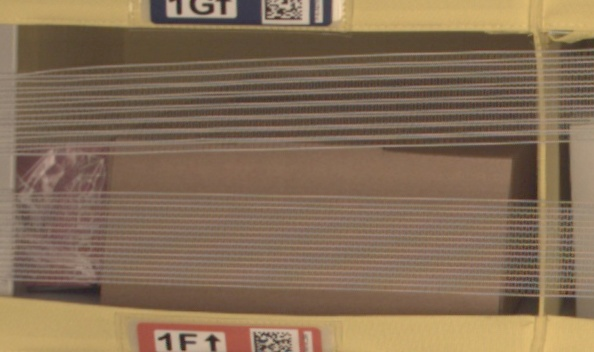

In [5]:
import boto3
from PIL import Image
from io import BytesIO
import json
from tqdm import tqdm

def get_abid_img(idx:int):
    """
    Retrieves a PIL Image from an image index.

    Parameters:
        idx (int) : index from the ABID Challenge Dataset.

    Returns:
        PIL.Image.Image: The PIL Image object if successful.
        None: If there is an error.
    """
    s3 = boto3.client('s3')
    bucket_name = "aft-vbi-pds"
    object_key = f"bin-images/{idx}.jpg"
    
    
    try:
        # Fetch the object from S3
        response = s3.get_object(Bucket=bucket_name, Key=object_key)
        
        # Read the content and load it as a PIL image
        image_data = response['Body'].read()
        pil_image = Image.open(BytesIO(image_data))
        
        return pil_image
    except Exception as e:
        return None

get_abid_img(83501)

### Create data loaders in pytorch

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
import random 
import json
import boto3
from PIL import Image
from io import BytesIO

class AbidImageDataset(Dataset):
    def __init__(self, dataset_json_file, transform=None, target_transform=None, shuffle=None):
        # Load Data from json file
        with open(dataset_json_file, 'r') as f:
            self.data = json.load(f)

        # Load data transform
        self.transform = transform
        self.target_transform = target_transform
        self.shuffle = shuffle
        
    def __len__(self):
        return len(self.data)

    @staticmethod
    def get_abid_img(idx:int):
        """
        Retrieves a PIL Image from an image index.
        """
        s3 = boto3.client('s3')
        bucket_name = "aft-vbi-pds"
        object_key = f"bin-images/{idx}.jpg"
        try:
            response = s3.get_object(Bucket=bucket_name, Key=object_key)
            image_data = response['Body'].read()
            pil_image = Image.open(BytesIO(image_data))
            return pil_image
        except Exception as e:
            print(f"Error retrieving image from S3: {e}")
            return None
            
    def __getitem__(self,idx):
        # Retrieve images and labels
        if self.shuffle:
            random.shuffle(self.data[idx])
            
        images = [self.get_abid_img(x[0]) for x in self.data[idx]]
        labels = [x[1] for x in self.data[idx]]

        # Apply transformations to images
        if self.transform:
            images = [self.transform(img) for img in images]
        else:
            images = [torch.tensor(img) for img in images]

        # Stack images into a single tensor
        images = torch.stack(images)  # Shape: [batch_size, channels, height, width]

        # Apply transformations to labels
        if self.target_transform:
            labels = [self.transform(label) for label in labels]
        else:
            labels = [torch.tensor(label) for label in labels]

        # Stack label into a single tensor
        labels = torch.stack(labels)  # Shape: [batch_size]
        return images, labels

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
        ])
valid_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
        ])
train_dt = AbidImageDataset('counting_filtered_train.json', transform=train_transform, shuffle=True)
valid_dt = AbidImageDataset('counting_filtered_valid.json', transform=valid_transform, shuffle=True)

In [5]:
for x,y in train_dt:
    print(f"Image Shape: {x.shape}")
    print(f"Label Shape: {y.shape}")
    for xi in x:
        print(xi.shape)
    print(f"Batches: {len(train_dt)}")
    break

for x,y in valid_dt:
    print(f"Image Shape: {x.shape}")
    print(f"Label Shape: {y.shape}")
    print(f"Batches: {len(valid_dt)}")
    break

Image Shape: torch.Size([13, 3, 224, 224])
Label Shape: torch.Size([13])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
Batches: 400
Image Shape: torch.Size([13, 3, 224, 224])
Label Shape: torch.Size([13])
Batches: 80


In [4]:
# Dataloaders
# Data is already organized in batches so the batch_size is None and shuffle True the batches are not always passed as the same
train_data_loader = torch.utils.data.DataLoader(train_dt, batch_size=None, shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid_dt, batch_size=None, shuffle=True)

In [5]:
for x,y in train_data_loader:
    print(f"Input Shape: {x.shape}")
    print(f"Label shaped: {y.shape}")
    break

Input Shape: torch.Size([13, 3, 224, 224])
Label shaped: torch.Size([13])


### Algorithms and Techniques
- For the algorithms we will used pretrained weights for the challenge to leverage specific features, and we will test adding different head on top of the models.
- We can also predict based on clases and calculate CrossEntropyLoss as error or predict a single number round it and calculate rmse for the error. We will test both approaches

### DNN Head
- This is the algorithm that is implemented as benchmark in the ABID Challenge paper https://github.com/silverbottlep/abid_challenge
- Consist of Resnet34 Backbone which extract features from the images and on top we used a Deep Neural Network to predict classes
- The backbone we will used is pretained in the challenge, but the head will be train from scratch to allow fai comparison to other alogirithms
- The backbone was train to count up to 6 object, we will use it to count up to 12

In [6]:
class DNN_HEAD(nn.Module):
    def __init__(self, n_classes, ln_reg=None):
        super().__init__()

        # Initialize resnet
        self.resnet34 = models.resnet34()
        in_features = self.resnet34.fc.in_features
        self.resnet34 = nn.Sequential(*list(self.resnet34.children())[:-1])
        self.ln_reg = ln_reg

        # Add the Flatten layer
        self.flatten = nn.Flatten()
        
        # Create classfication head
        self.Linear = nn.Linear(in_features, n_classes)

        # Add Linear Regression Layer if used
        if self.ln_reg:
            self.Reg = nn.Linear(n_classes, 1)

    def freeze_backbone(self):
        for param in self.resnet34.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet34(x)
        x = self.flatten(x)
        x = self.Linear(x)
        if self.ln_reg:
            x = self.Reg(x)
        return x

In [7]:
# We will estimate up until 12 objects countin no object there will be 13 classes
N_CLASSES = 13
# Build the network
net = DNN_HEAD(N_CLASSES)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print(out.shape)
    print(out)

/tmp/ipykernel_3368/2157091171.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


torch.Size([1, 13])
tensor([[  30.5802,   30.8671,   -8.2713,  -17.3004,    0.3819,  -15.8221,
           -9.3512, -102.8679,   64.1845,   12.0586,   31.1559,    1.0619,
          -10.6154]])


In [27]:
# With Regression
# Build the network
net = DNN_HEAD(N_CLASSES,ln_reg=True)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print(out.shape)
    print(out)

torch.Size([1, 1])
tensor([[-2.6739]])


/tmp/ipykernel_108/4066498144.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


### CNN Head
- In this case we will add a Convolutional Neural Network on top of the pretained netword and before the classification or regression head
- the hypothesis is using the CNN Head we will get additional trainable space features without retraining all weights, allowing to capture dataset specific space features wihtout training all the parameters

In [29]:
class CNN_HEAD(nn.Module):
    def __init__(self, n_classes, ln_reg=None):
        super().__init__()

        # Initialize resnet
        self.resnet34 = models.resnet34()
        in_features = self.resnet34.fc.in_features
        self.resnet34 = nn.Sequential(*list(self.resnet34.children())[:-2])
        self.ln_reg = ln_reg

        # Add a convolutional layer to learn specific features
        self.conv = nn.Conv2d(in_features, 256, kernel_size=3, padding=1)  # Convolutional layer
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        
        # Add Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add the Flatten layer
        self.flatten = nn.Flatten()
        
        # Create classfication head
        self.Linear = nn.Linear(256, n_classes)

        # Add Linear Regression Layer if used
        if self.ln_reg:
            self.Reg = nn.Linear(n_classes, 1)

    def freeze_backbone(self):
        for param in self.resnet34.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet34(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.Linear(x)
        if self.ln_reg:
            x = self.Reg(x)
        return x

In [32]:
# With Classification
# Build the network
net = CNN_HEAD(N_CLASSES)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Classification")
    print(out.shape)
    print(out)

# With Regression
net = CNN_HEAD(N_CLASSES,ln_reg=True)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Regression")
    print(out.shape)
    print(out)

/tmp/ipykernel_108/2065835405.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Classification
torch.Size([1, 13])
tensor([[-17.0609,   6.3631, -14.7591, -14.6191, -67.1944,   0.9696,  -5.6914,
          32.8361, -14.5028,  12.2867,   9.2166, -24.1895, -18.9165]])


/tmp/ipykernel_108/2065835405.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Regression
torch.Size([1, 1])
tensor([[40.0253]])


### Attention Head

In [31]:
class ATT_HEAD(nn.Module):
    def __init__(self, n_classes, embed_dim=512, num_heads=8, ln_reg=None):
        super().__init__()

        # Initialize ResNet34
        self.resnet34 = models.resnet34()
        self.resnet34 = nn.Sequential(*list(self.resnet34.children())[:-2])  # Remove the last two layers
        self.ln_reg = ln_reg

        # Multihead Attention
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

        # Adaptive average pooling to maintain compatibility
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(embed_dim, n_classes)

        # Add Linear Regression Layer if used
        if self.ln_reg:
            self.Reg = nn.Linear(n_classes, 1)

    def freeze_backbone(self):
        for param in self.resnet34.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet34(x)  # Extract features
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # Reshape to (batch_size, num_patches, channels)
        x, _ = self.attention(x, x, x)  # Apply self-attention
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)  # Reshape back
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        if self.ln_reg:
            x = self.Reg(x)
        return x

In [33]:
# With Classification
# Build the network
net = ATT_HEAD(N_CLASSES)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Classification")
    print(out.shape)
    print(out)

# With Regression
net = ATT_HEAD(N_CLASSES,ln_reg=True)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Regression")
    print(out.shape)
    print(out)

/tmp/ipykernel_108/1706150787.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Classification
torch.Size([1, 13])
tensor([[ -5.9910,   9.8992,  19.4592,   6.9507,  -5.3544,  11.5128,   2.5888,
          -7.9725,  -9.5374, -11.2414,  -2.6056, -34.4744,  -3.6208]])


/tmp/ipykernel_108/1706150787.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Regression
torch.Size([1, 1])
tensor([[-4.0317]])


### Multiple CNN HEAD
- For this we will use CNN of mutiple kernel sizes to count objects of different sizes

In [2]:
class MULTIPLE_CNN_HEAD(nn.Module):
    def __init__(self, n_classes, out_features=256, ln_reg=None):
        super().__init__()

        # Initialize resnet
        self.resnet34 = models.resnet34()
        in_features = self.resnet34.fc.in_features
        self.resnet34 = nn.Sequential(*list(self.resnet34.children())[:-2])
        self.ln_reg = ln_reg
        
        # Create multiple convolutional layers with different kernel sizes and specified output features
        kernel_sizes = [(21, 63), (21, 63), (21, 21)]
        self.convs = nn.ModuleList([
            nn.Conv2d(in_features, out_features, kernel_size=k, padding=[ki//2 for ki in k]) for k in kernel_sizes
        ])
        
        self.relu = nn.ReLU(inplace=True)  # ReLU activation
        
        # Add Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add the Flatten layer
        self.flatten = nn.Flatten()
        
        # Adjust Linear layer to account for different numbers of convolutional outputs
        self.Linear = nn.Linear(out_features * len(kernel_sizes), n_classes)

        # Add Linear Regression Layer if used
        if self.ln_reg:
            self.Reg = nn.Linear(n_classes, 1)

    def freeze_backbone(self):
        for param in self.resnet34.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet34(x)

        # Apply each convolution and concatenate their outputs
        x = torch.cat([self.relu(conv(x)) for conv in self.convs], dim=1)
        
        # Global Average Pooling and Flatten
        x = self.gap(x)
        x = self.flatten(x)
        
        # Classification head
        x = self.Linear(x)

        if self.ln_reg:
            x = self.Reg(x)
        return x

In [3]:
N_CLASSES = 13
# With Classification
# Build the network
net = MULTIPLE_CNN_HEAD(N_CLASSES)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Classification")
    print(out.shape)
    print(out)

# With Regression
del net
net = MULTIPLE_CNN_HEAD(N_CLASSES,ln_reg=True)
# Load weight and freeze parameters
checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")
net.load_state_dict(checkpoint['state_dict'], strict=False)
net.freeze_backbone()
# Dummy test
net.eval()
with torch.no_grad():
    dummy_input = torch.randn(1,3,224,224)
    out = net(dummy_input)
    print("Test with Regression")
    print(out.shape)
    print(out)

/tmp/ipykernel_5101/949779778.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Classification
torch.Size([1, 13])
tensor([[-1.2007,  0.5049, -0.9198,  3.8296, -5.6355,  3.3428,  5.0995, -1.0398,
         -2.7214,  2.1513, -0.7201, -1.4760, -6.9050]])


/tmp/ipykernel_5101/949779778.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet34_best_from_repo_cpu.pth.tar")


Test with Regression
torch.Size([1, 1])
tensor([[-5.1365]])


### Benchmarks
To benchmark the results we will use Accuracy and RMSE Error as Metric

## 3. Methodology

### Data preprocessing
- As we are using resnet34 backbone we need to resize the images to 3x224x224
- We need then to normalize images with the same process resnet34 was trained
- The label values are just integer and wont be further process

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
        ])
valid_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
        ])

### Implementation
- For the implementation we will design a train template which will use the different models
- We will proper metric loggings so later on we can compare the results
- Each model will be trained on different compute instance levereging AWS Sagemaker tools

### Training Template

In [ ]:
import time

def get_model(model_name, n_classes, ln_reg=None, cuda=None, checkpoint_path=None):
    if model_name == "DNN_HEAD":
        model = DNN_HEAD(n_classes,ln_reg=ln_reg)
    elif model_name == "CNN_HEAD":
        model = CNN_HEAD(n_classes, ln_reg=ln_reg)
    elif model_name == "ATT_HEAD":
        model = ATT_HEAD(N_CLASSES,ln_reg=ln_reg)
    elif model_name == "MULTIPLE_CNN_HEAD":
        model = MULTIPLE_CNN_HEAD(N_CLASSES,ln_reg=ln_reg)
    else:
        return None

    if checkpoint_path:
        if os.path.isfile(checkpoint_path):
            print(f"Loading Checkpoint {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
        else:
            return None

    if ln_reg:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
        
    if cuda:
        model.cuda()
        criterion = criterion.cuda()

    model.freeze_backbone()

    return model, criterion


def get_data_loaders(train_data_json:str, valid_data_json:str):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
            ])
    valid_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
            ])

    # Check we have received correct path
    if not os.path.isfile(train_data_json) or not os.path.isfile(valid_data_json):
        return None

    train_dt = AbidImageDataset(train_data_json, transform=train_transform, shuffle=True)
    valid_dt = AbidImageDataset(valid_data_json, transform=valid_transform, shuffle=True)
    train_data_loader = torch.utils.data.DataLoader(train_dt, batch_size=None, shuffle=True)
    valid_data_loader = torch.utils.data.DataLoader(valid_dt, batch_size=None, shuffle=True)
    
    return train_data_loader, valid_data_loader

def transform_input_inference(x):
    tx = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
            ])
    return tx(x)

        
def train(model, criterion, optimizer, lr, data_loader, ln_reg=None, cuda=None):
    model.train()
    mse_loss = nn.MSELoss()
    
    # Training model
    for i, (x, yg) in enumerate(data_loader):
        # Send data to gpu
        if cuda:
            x = x.cuda()
            yg = yg.cuda()

        # Forward propagation
        yp = model(x)
        loss = criterion(yp, yg)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

    # Calculate metric on static values
    model.eval()
    metrics = {'acc':0 , 'mse':0, 'loss':0}
    
    for i, (x, yg) in enumerate(data_loader):
        # Send data to gpu
        if cuda:
            x = x.cuda()
            yg = yg.cuda()

        # Forward propagation
        with torch.no_grad():
            yp = model(x)
            loss = criterion(yp, yg)
            metrics['loss'] = metrics['loss'] + loss

        # Process output
        if ln_reg:
            predicted = torch.round(yp).long()
        else:
            score, predicted = torch.max(yp, dim=1)
            
        # Accuracy
        correct = float((yg == predicted).sum().item())
        total_samples = x.size(0)
        acc = (correct / total_samples)
        metrics['acc'] = metrics['acc'] + acc
        # RMSE
        mse = mse_loss(predicted).item()
        metrics['mse'] = metrics['mse'] + mse

    for mtr in metrics.keys():
        metrics[mtr] = metrics[mtr]/len(data_loader)

    return metrics


def validate(model, criterion, data_loader, ln_reg=None, cuda=None):
    model.eval()
    mse_loss = nn.MSELoss()

    metrics = {'acc':0 , 'mse':0, 'loss':0}
        
    for i, (x, yg) in enumerate(data_loader):
        # Send data to gpu
        if cuda:
            x = x.cuda()
            yg = yg.cuda()

        # Forward propagation
        with torch.no_grad():
            yp = model(x)
            loss = criterion(yp, yg)
            metrics['loss'] = metrics['loss'] + loss

        # Process output
        if ln_reg:
            predicted = torch.round(yp).long()
        else:
            score, predicted = torch.max(yp, dim=1)
                
        # Accuracy
        correct = float((yg == predicted).sum().item())
        total_samples = x.size(0)
        acc = (correct / total_samples)
        metrics['acc'] = metrics['acc'] + acc
        # RMSE
        mse = mse_loss(predicted).item()
        metrics['mse'] = metrics['mse'] + mse

    for mtr in metrics.keys():
        metrics[mtr] = metrics[mtr]/len(data_loader)

    return metrics

def run(model_name, n_classes, ln_reg, checkpoint_path, epochs, lr,evaluate, train_data_json, valid_data_json, new_checkpoint_path):
    # Get model
    cuda = torch.cuda.is_available()
    model, criterion = get_model(model_name, n_classes, ln_reg, cuda, checkpoint_path)
    train_loader, valid_loader = get_data_loaders(train_data_json, valid_data_json)
    
    if evaluate:
        val_metrics = validate(model, criterion, valid_loader, ln_reg, cuda)
        return None, val_metrics
        
    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=lr)

    for epoch in range(epochs):
        train_metrics = train(model, criterion, optimizer, lr, train_loader, ln_reg, cuda)
        val_metrics = validate(model, criterion, valid_loader, ln_reg, cuda)
        
    torch.save({
        "arch" : model_name,
        "state_dict":model.state_dict(),
    },new_checkpoint_path)

    return train_metrics, val_metrics

### AWS Training
- From the previous template we create a script "train.py" to use AWS estimators
- We also specify the data path and output path in S# buckets

In [4]:
import os
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput

#### Cleaning Data
- After trying to run the script we found that here some images not found from our index list, in order to clean the data we will use the a new script to find verified images on the same proportion we previously decided per category

In [2]:
[0]*13

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

train = []
train_cat = [0]*13
clean_train = []
# Read train file
with open("counting_train_hard.json",'r') as f:
    train = json.load(f)
otd = len(train)
print(f"Original Lenght of Train Data: {otd}")
# Clean train file
pbar = tqdm(total=5200, desc="Process of Train Data Cleaning", bar_format='{l_bar}{bar:20}{r_bar}')
for index, x in enumerate(train):
    if x[1] < len(train_cat) and train_cat[x[1]] < 400:
        if get_abid_img(x[0]) is not None:
            train_cat[x[1]] = train_cat[x[1]]+1
            clean_train.append(x)
            pbar.update(1)
            
# Saved train file
with open("counting_cleaned_train.json",'w') as f:
    json.dump(clean_train,f)

df = pd.DataFrame(clean_train).groupby(1)
df.size().plot(kind='bar', title="Training Images groupby number of objects - Balanced")
plt.show()

valid = []
valid_cat = [0]*13
clean_valid = []
# Read valid file
with open("counting_val_hard.json",'r') as f:
    valid = json.load(f)
ovd = len(valid)
print(f"Original Lenght of Train Data: {ovd}")

# Clean train file
pbar = tqdm(total=1040, desc="Process of Valid Data Cleaning", bar_format='{l_bar}{bar:20}{r_bar}')
for index, x in enumerate(valid):
    if x[1] < len(valid_cat) and valid_cat[x[1]] < 80:
        if get_abid_img(x[0]) is not None:
            valid_cat[x[1]] = valid_cat[x[1]]+1
            clean_valid.append(x)
            pbar.update(1)
        
# Saved train file
with open("counting_cleaned_valid.json",'w') as f:
    json.dump(clean_valid,f)

df = pd.DataFrame(clean_valid).groupby(1)
df.size().plot(kind='bar', title="Validation Images groupby number of objects - Balanced")
plt.show()

In [22]:
import pandas as pd
import json

with open('counting_cleaned_train.json','r') as f:
    clean_train_dt = pd.DataFrame(json.load(f)).groupby(1)

with open('counting_cleaned_valid.json','r') as f:
    clean_valid_dt = pd.DataFrame(json.load(f)).groupby(1)

# Grouping the data in batches
# We then proced to get it formated as batches

ntrain = []
nvalid = []

N_TRAIN_BATCHES = 400
N_VALID_BATCHES = 80

for x in range(N_TRAIN_BATCHES):
    batch = clean_train_dt.nth(x)
    ntrain.append(batch.values.tolist())

for x in range(N_VALID_BATCHES):
    batch = clean_valid_dt.nth(x)
    nvalid.append(batch.values.tolist())

with open('counting_cleaned_train.json', 'w', encoding='utf-8') as f:
    json.dump(ntrain, f, indent=4)

with open('counting_cleaned_valid.json', 'w', encoding='utf-8') as f:
    json.dump(nvalid, f, indent=4)
    

#### Upload files to S3 Buckets

In [23]:
# Upload necessary Data to S3 Bucket
s3_client = boto3.client('s3')

# Data files
f1 = 'counting_cleaned_train.json'
f2 = 'counting_cleaned_valid.json'
f3 = 'resnet34_best_from_repo_cpu.pth.tar'

# Specify the target S3 bucket and object key
bucket_name = 'abid-data'
obj1 = f'data/{f1}'
obj2 = f'data/{f2}'
obj3 = f'snapshots/{f3}'

# Upload the file
s3_client.upload_file(f1, bucket_name, obj1)
s3_client.upload_file(f2, bucket_name, obj2)
s3_client.upload_file(f3, bucket_name, obj3)


In [ ]:
import os
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput

hyperparameter_ranges = {
    "learning_rate": CategoricalParameter([0.0001, 0.001]),
    "model_name": CategoricalParameter(["DNN_HEAD", "CNN_HEAD", "ATT_HEAD", "MULTIPLE_CNN_HEAD"]),
    "type_of_inference": CategoricalParameter(["linear_regression", "classification"])
}

role = sagemaker.get_execution_role()

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "acc: ([0-9\\.]+)"}]


estimator = PyTorch(
    entry_point="train.py",
    base_job_name='pytorch_abid',
    role=role,
    framework_version="2.3",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py311',
    hyperparameters={"n_classes": 13,
                     "epochs": 10,
                     "checkpoint_name": "resnet34_best_from_repo_cpu.pth.tar",
                     "type_of_inference": "linear_regression"},
    output_path="s3://abid-data/snapshots/"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=16,
    max_parallel_jobs=2,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

# Personal dataset
project_data = TrainingInput(
    s3_data="s3://abid-data/",
    input_mode='File'  # Options: 'File', 'Pipe', 'FastFile'
)

data_channels = {
    'project_data': project_data
}

# Start the training job
tuner.fit(inputs=data_channels)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## 4. Analysis

### Model Evaluation and Validation

In [16]:
import boto3
import os
import tarfile

s3 = boto3.client('s3')
bucket = 'abid-data'
resp = s3.list_objects_v2(Bucket=bucket,Prefix='snapshots')
objs = [x['Key'] for x in resp['Contents'] if x['Key'].startswith("snapshots/pytorch-training")]
for index, obj in enumerate(objs):
    print(obj)
    fpath = os.path.join("results", f"out_{index+1}")
    s3.download_file(bucket, obj, fpath+".tar.gz")
    with tarfile.open(fpath+".tar.gz",'r:gz') as tar:
        tar.extractall(path=fpath)
    os.remove(fpath+".tar.gz")

snapshots/pytorch-training-241203-0043-001-14474bd3/output/output.tar.gz
snapshots/pytorch-training-241203-0043-002-ffcbab35/output/output.tar.gz
snapshots/pytorch-training-241203-0043-003-5c8fbed7/output/output.tar.gz
snapshots/pytorch-training-241203-0043-004-d477d83b/output/output.tar.gz
snapshots/pytorch-training-241203-0043-005-65816d61/output/output.tar.gz
snapshots/pytorch-training-241203-0043-006-9c45d1df/output/output.tar.gz
snapshots/pytorch-training-241203-0043-007-0f6096ae/output/output.tar.gz
snapshots/pytorch-training-241203-0043-008-35982f01/output/output.tar.gz
snapshots/pytorch-training-241203-0043-009-72c57cf9/output/output.tar.gz
snapshots/pytorch-training-241203-0043-010-aea56249/output/output.tar.gz
snapshots/pytorch-training-241203-0043-011-b60844b0/output/output.tar.gz
snapshots/pytorch-training-241203-0043-012-b68508af/output/output.tar.gz
snapshots/pytorch-training-241203-0043-013-59c5926d/output/output.tar.gz
snapshots/pytorch-training-241203-0043-014-1374389e

In [19]:
from tabulate import tabulate
import os
import json

metrics = []
for folder in os.listdir('results'):
    for file in os.listdir(os.path.join('results',folder)):
        if file.endswith('.json'):
            with open(os.path.join('results',folder,file),'r') as jfile:
                data = json.load(jfile)
                for k in data['train'].keys():
                    data[f'train_{k}'] = data['train'][k]
                data.pop('train')
                for k in data['val'].keys():
                    data[f'val_{k}'] = data['val'][k]
                data.pop('val')
            metrics.append(data)

In [20]:
metrics

[{'lr': 0.0001,
  'model_name': 'DNN_HEAD',
  'n_classes': 13,
  'type_of_inference': 'linear_regression',
  'epochs': 10,
  'initial_checkpoint_weights': 'resnet34_best_from_repo_cpu.pth.tar',
  'train_acc': 0.07596153846153825,
  'train_mse': 13.96769312620163,
  'train_loss': 13.851885595321654,
  'val_acc': 0.07596153846153841,
  'val_mse': 13.999039280414582,
  'val_loss': 13.953598701953888},
 {'lr': 0.001,
  'model_name': 'CNN_HEAD',
  'n_classes': 13,
  'type_of_inference': 'classification',
  'epochs': 10,
  'initial_checkpoint_weights': 'resnet34_best_from_repo_cpu.pth.tar',
  'train_acc': 0.076730769230769,
  'train_mse': 17.996923086643218,
  'train_loss': 2.5648987245559693,
  'val_acc': 0.07788461538461533,
  'val_mse': 18.030769252777098,
  'val_loss': 2.5649490475654604},
 {'lr': 0.0001,
  'model_name': 'ATT_HEAD',
  'n_classes': 13,
  'type_of_inference': 'classification',
  'epochs': 10,
  'initial_checkpoint_weights': 'resnet34_best_from_repo_cpu.pth.tar',
  'train_a

In [22]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.1 MB/s eta 0:00:00


In [23]:
from itables import show
import pandas as pd

keys = metrics[0].keys()
formated_metrics ={}
for key in keys:
    formated_metrics[key] = []
    for metric in metrics:
        formated_metrics[key].append(metric[key])

df = pd.DataFrame(formated_metrics)
show(df)

In [24]:
df.to_csv(os.path.join('results','metrics.csv'))

## Model Evaluation
### Baseline Performance:
The baseline approach proposed by the challenge utilized the DNN_HEAD with a classification head. The benchmark accuracy on the validation set was 14.73% (with learning rate = 0.001) and 11.05% (with learning rate = 0.0001). Comparing this to our models' performance, we observe the following:

The MULTIPLE_CNN_HEAD model delivered the highest accuracy, but the improvement over the baseline was marginal, approximately 0.1%.
Classification models performed better on the training set; however, these improvements did not generalize effectively to the validation set.

### Root Mean Squared Error (RMSE):
The baseline RMSE for DNN_HEAD was 31 (lr = 0.0001) and 28 (lr = 0.001).

Models using a linear regression head with RMSE loss outperformed others on this metric. Due to their continuous nature, these models demonstrated better accuracy in estimating approximate quantities. In scenarios where being close to the actual quantity is more important, linear regression models outperform classification models.
The best-performing model was the DNN_HEAD with a linear regression head, followed closely by models with a convolutional head.

### Impact of Learning Rate:
Models trained with a learning rate of 0.001 consistently outperformed those with a learning rate of 0.0001. This suggests that the lower learning rate is less effective in fitting the data.

### Recommendations:
To achieve better results, we propose using the DNN_HEAD with a linear regression head, a learning rate of 0.001, and training for additional epochs to improve model performance further.

## Improvements

In [ ]:
import os
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()

objective_metric_name = "Accuracy"
metric_definitions = [{"Name": "Accuracy", "Regex": "acc: ([0-9\\.]+)"}]


estimator = PyTorch(
    entry_point="train.py",
    base_job_name='abid',
    role=role,
    framework_version="2.3",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py311',
    hyperparameters={"n_classes": 13,
                     "epochs": 100,
                     "checkpoint_name": "DNN_HEAD_linReg.pth.tar",
                     "type_of_inference": "linear_regression",
                     "learning_rate": 0.001,
                     "model_name": "DNN_HEAD"},
    output_path="s3://abid-data/snapshots/",
    metric_definitions=metric_definitions
)

# Personal dataset
project_data = TrainingInput(
    s3_data="s3://abid-data/",
    input_mode='File'  # Options: 'File', 'Pipe', 'FastFile'
)

data_channels = {
    'project_data': project_data
}

# Start the training job
estimator.fit(inputs=data_channels)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: abid-2024-12-04-03-01-31-379


2024-12-04 03:01:31 Starting - Starting the training job...
2024-12-04 03:01:53 Starting - Preparing the instances for training...
2024-12-04 03:02:22 Downloading - Downloading input data...
2024-12-04 03:03:03 Downloading - Downloading the training image........................
2024-12-04 03:06:50 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.11/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.11/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.Tri

In [3]:
import boto3

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Replace with your training job name
training_job_name = 'abid-2024-12-04-03-01-31-379'

# Get training job details
response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

# Extract metrics
final_metrics = response.get('FinalMetricDataList', [])
for metric in final_metrics:
    print(f"{metric['MetricName']}: {metric['Value']}")


Accuracy: 0.08615384250879288


## Final Conclusions

### Model Improvements and Observations
- Additional Epochs: Extending training epochs yielded only marginal improvements. This could be attributed to limitations in the optimization algorithm or the model’s inherent inability to generalize to the data effectively. Notably, results showcased in [Abid Challenge Repo](https://github.com/silverbottlep/abid_challenge) under section 4.3 demonstrate that using a different optimization algorithm led to significantly better performance. Therefore, future work should prioritize experimenting with alternative optimization algorithms and re-evaluating previously tested models.

- Model Selection: Among the explored models, the DNN_HEAD with a regression head emerged as the preferred choice over the baseline DNN_HEAD with a classification head. The regression head enables continuous estimation, which proved advantageous in tasks where we can leverage continuity of the solution, number of objects

## Performance Relative to Existing Benchmarks
- Limitations of Current Approach: Despite achieving some advancements, our approach did not outperform publicly available models tailored to this task. For instance, the baseline solution trained using the script from [Abid Challenge Repo](https://github.com/silverbottlep/abid_challenge) achieved accuracies up to 40% and rmse as low as 1.3 but focused exclusively on six classes (0 to 5 objects).

## Recommendations for Future Work
- Optimization Algorithms: Investigate and integrate alternative optimization algorithms to enhance model convergence and performance.
- Model Generalization: Conduct further research into improving the generalization capabilities of the model, possibly through regularization techniques or additional data preprocessing.
- Comparison with Public Models: Perform an in-depth comparison of our methods with state-of-the-art publicly available models to identify gaps and areas for improvement.
- Focus on Continuous Estimation: Continue refining models with regression heads, as these have shown promise in delivering better approximations for quantity estimation tasks.

While the results demonstrate potential, they also highlight the need for further experimentation and optimization to get a more in depth view of the problem at hand.